# Using Julia to Solve DE

## Read in data, Plot


In [1]:
using CSV, DataFrames, StatsPlots


In [2]:
# Read in data
cols = ["theta", "theta_d", "x", "x_d", "forceIn", "theta_dd", "x_dd"]
df = CSV.read("../../../Data/deterministicCase/deterministicData.csv", DataFrame, header=cols)
df

Row,theta,theta_d,x,x_d,forceIn,theta_dd,x_dd
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.3,1.0,0.0,0.0,-0.2,4.88965,-0.380716
2,0.310489,1.0489,-3.80716e-5,-0.00380716,-0.170018,4.99911,-0.355648
3,0.321478,1.09889,-0.000111708,-0.00736364,-0.140144,5.11525,-0.330657
4,0.332978,1.15004,-0.00021841,-0.0106702,-0.110485,5.23828,-0.305812
5,0.345002,1.20242,-0.000355693,-0.0137283,-0.0811487,5.36837,-0.281177
6,0.357564,1.25611,-0.000521094,-0.0165401,-0.0522399,5.50567,-0.256812
7,0.370675,1.31116,-0.000712176,-0.0191082,-0.0238629,5.65036,-0.232769
8,0.384352,1.36767,-0.000926535,-0.0214359,0.00388023,5.80256,-0.209092
9,0.398609,1.42569,-0.0011618,-0.0235268,0.0308896,5.9624,-0.185818


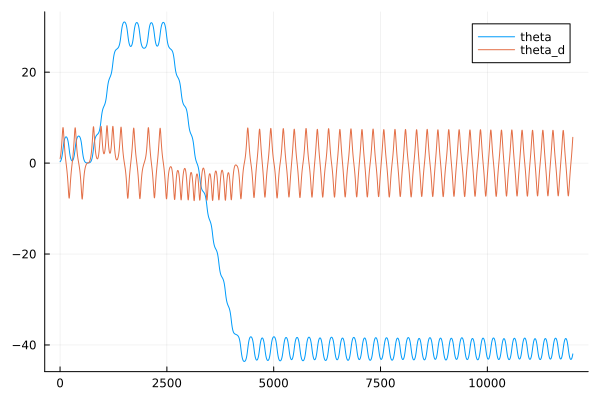

In [3]:

@df df plot(cols(1:2))


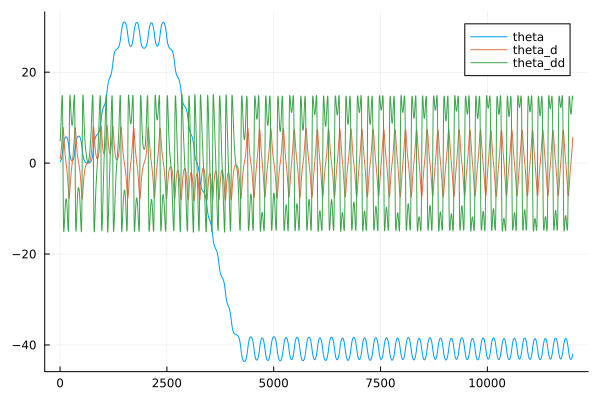

In [8]:

@df df plot([:theta :theta_d :theta_dd])


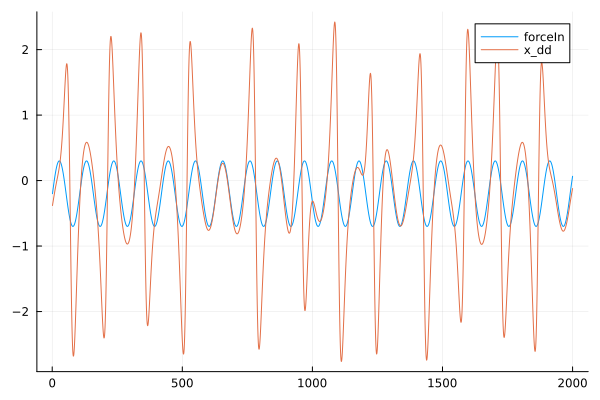

In [17]:

@df first(df, 2000) plot([:forceIn :x_dd])


## Solving Differential Equation

1. Create function representing the diffeq
2. Input initial conditions
3. Solve
4. Match to generated data

### Creating diffeq function

General form is `f(u, p, t) = du/dt` where u is the variable of interest, p are the parameters of the model, and t is time.

From the recommended source <https://sharpneat.sourceforge.io/research/cart-pole/cart-pole-equations.html>, the cartpole equations are:

$$\ddot{x}=\frac{f-ml\ddot{\theta}\cos{\theta} +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x}}{m_c + m}$$

$$\ddot{\theta}=\frac{Mg\sin{\theta} -\cos{\theta}(f +ml\dot{\theta}^2\sin{\theta}-\mu_c\dot{x})-\frac{M\mu_p\dot{\theta}}{ml}}{(1+k)Ml-ml\cos^2{\theta}}$$


Where:

$f = $ External horizontal force

$m = $ Pendulum's mass

$l = $ Length of the pendulum rod

$m_c = $ Mass of the cart

$M = $ Combined mass of cart and pendulum, i.e. $m_c + m$

$g = $ gravitational acceleration (9.8 m/s^2), signed positive

$k = $ Some constant to be substituted later...1/3?

$x, \dot{x}, \ddot{x}$ horizontal position, velocity, and acceleration of the cart. Positive = right

$\theta, \dot{\theta}, \ddot{\theta}$ Angle of pendulum, angular velocity and acceleration. Positive = clockwise, $0^{\circ}$ = vertical


From `cartPoleDyn` function, using `pytexit`:

$$\theta_{dd}=\frac{\left(m1+m2\right) gravity sin\left(\theta\right)-cos\left(\theta\right) \left(force+m2 length {\theta_d}^2 sin\left(\theta\right)-\mu_c x_d\right)-\frac{\left(m1+m2\right) \mu_p \theta_d}{m2 length}}{\left(m1+m2\right) \left(k_{inertia}+1\right) length-m2 length {cos\left(\theta\right)}^2}$$
$$x_{dd}=\frac{force-m2 length \left(\theta_{dd} cos\left(\theta\right)-{\theta_d}^2 sin\left(\theta\right)\right)-\mu_c x_d}{m1+m2}$$

They seem to match up.

Following this page: <https://diffeq.sciml.ai/stable/types/dynamical_types/>

> f should be specified as f(du,u,p,t) (or in-place as f(ddu,du,u,p,t)), and u₀ should be an AbstractArray (or number) whose geometry matches the desired geometry of u.

In [31]:
function cartpole!(ddu, du, u, p, t)
    # Parameters
    m1, m2, gravity, length, mu_c, mu_p, k_inertia = p

    # theta_dd
    ddu[1] = ((m1+m2)*gravity*sin(u[1])-cos(u[1])*((-0.2+0.5*sin(6*t))+m2*length*(du[1]^2)*sin(u[1])-mu_c*du[2])-((m1+m2)*mu_p*du[1])/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(cos(u[1]))^2)
    
    # x_dd
    ddu[2] = ((-0.2+0.5*sin(6*t))-m2*length*(ddu[1]*cos(u[1])-(du[1]^2)*sin(u[1]))-mu_c*du[2]) / (m1+m2)
end

cartpole! (generic function with 1 method)

In [32]:
using DifferentialEquations

# Parameters (copying from `GPWithGPy.ipynb`)
p = (1.0, 0.1, 9.8, 0.5, 0.0005, 0.000002, 1/3)

# Initial conditions
u0 = [0.3, 0.0]
du0 = [1.0, 0.0]

# Solve
tspan = (0.0, 120.0)
prob = SecondOrderODEProblem(cartpole!, du0, u0, tspan, p)

ODEProblem with uType ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}} and tType Float64. In-place: true
timespan: (0.0, 120.0)
u0: ([1.0, 0.0], [0.3, 0.0])

In [33]:
sol = solve(prob)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 454-element Vector{Float64}:
   0.0
   0.0037061490460906753
   0.02582802388851519
   0.06918774943508924
   0.1275604475355786
   0.1982290940680197
   0.27608915406662415
   0.3622647681114052
   0.4584547536442426
   0.5665217691371174
   ⋮
 118.02767012857765
 118.33269185248854
 118.58079722490895
 118.86789115771556
 119.07656785004043
 119.2943518140446
 119.57376744442264
 119.81194900254545
 120.0
u: 454-element Vector{ArrayPartition{Float64, Tuple{Vector{Float64}, Vector{Float64}}}}:
 ([1.0, 0.0], [0.3, 0.0])
 ([1.0181928052874, -0.0013936669923217452], [0.3037398176315387, -2.5932680472402614e-6])
 ([1.1299031704305011, -0.00899335628330375], [0.32748962640501905, -0.00011975019919796822])
 ([1.3666396059709207, -0.02037389934586892], [0.381522119261746, -0.0007729969970067778])
 ([1.7316659831022316, -0.028758879866955585], [0.4716607911012505, -0.00224402782148581])
 ([2.2650564918846086, -0.029

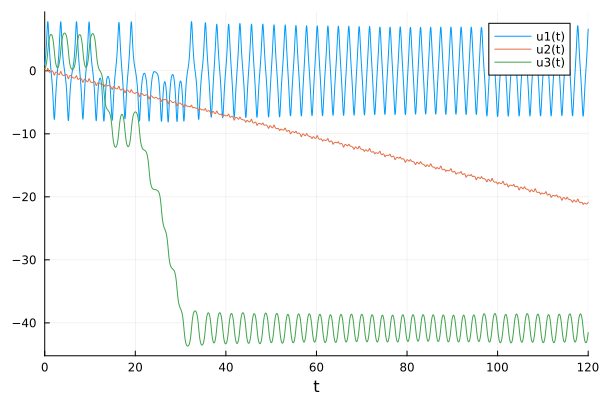

In [36]:
plot(sol, idxs=[1 2 3])